# Hardware simulators - gem5 target support
The gem5 simulator is a modular platform for computer-system architecture research, encompassing system-level architecture as well as processor microarchitecture.

Before creating the gem5 target, the inputs needed by gem5 should have been created (eg gem5 binary, kernel suitable for gem5, disk image, device tree blob, etc). For more information, see [GEM5 - Main Page](http://gem5.org/Main_Page).

# Environment setup

In [1]:
from conf import LisaLogging
LisaLogging.setup()

2017-07-19 09:55:37,733 INFO    : root         : Using LISA logging configuration:
2017-07-19 09:55:37,733 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
# One initial cell for imports
import json
import logging
import os

from env import TestEnv

# Suport for FTrace events parsing and visualization
import trappy
from trappy.ftrace import FTrace
from trace import Trace

# Support for plotting
# Generate plots inline
%matplotlib inline
import numpy
import pandas as pd
import matplotlib.pyplot as plt

2017-07-19 09:55:39,016 WARNING : EnergyModel  : Unusual max capacity (1023), overriding capacity_scale


# Target configuration
The definitions below need to be changed to the paths pointing to the gem5 binaries on your development machine.
M5_PATH needs to be set in your environment

   - **platform** - the currently supported platforms are:
        - linux - accessed via SSH connection
        
   - **board** - the currently supported boards are:
        - gem5 - target is a gem5 simulator
        
   - **host** - target IP or MAC address of the platform hosting the simulator
   
   - **gem5** - the settings for the simulation are:
       - **system**
           - **platform**
               - description - python description of the platform to simulate
               - args - arguments to be given to the python script (./gem5.fast model.py --help)
               
           - kernel - kernel image to run on the simulated platform
           - dtb - dtb of the platform to simulate
           - disk - disk image to run on the platform
       - **simulator**
            - bin - path to the gem5 simulator binary
            - args - arguments to be given to the gem5 binary (./gem5.fast --help)

   - **modules** - devlib modules to be enabled
    
   - **exclude_modules** - devlib modules to be disabled
    
   - **tools** - binary tools (available under ./tools/$ARCH/) to install by default
    
   - **ping_time** - wait time before trying to access the target after reboot
    
   - **reboot_time** - maximum time to wait after rebooting the target
    
   - **__features__** - list of test environment features to enable
        - no-kernel - do not deploy kernel/dtb images
        - no-reboot - do not force reboot the target at each configuration change
        - debug - enable debugging messages
     
   - **ftrace** - ftrace configuration
       - events
       - functions
       - buffsize
    
   - **results_dir** - location of results of the experiments


In [3]:
# Root path of the gem5 workspace
base = "/home/vagrant/gem5/"

conf = {
    # Only 'linux' is supported by gem5 for now
    # 'android' is a WIP
    "platform"    : 'linux',
    
    # Preload settings for a specific target
    "board"       : 'gem5',

    # Host that will run the gem5 instance
    "host"        : "workstation-lin",
    
    "gem5" : {
        # System to simulate
        "system" : {
            # Platform description
            "platform" : {
                # Gem5 platform description
                # LISA will also look for an optional gem5<platform> board file
                # located in the same directory as the description file.
                "description" : os.path.join(base, "juno.py"),
                "args" : [
                    "--atomic",
                    # Resume simulation from a previous checkpoint
                    # Checkpoint must be taken before Virtio folders are mounted
                    # "--checkpoint-indir " + os.path.join(base, "Juno/atomic/",
                    #                                      "checkpoints"),
                    # "--checkpoint-resume 1",
                ]
            },
            # Kernel compiled for gem5 with Virtio flags
            "kernel"   : os.path.join(base, "platform_juno/", "vmlinux"),
            # DTB of the system to simulate
            "dtb"      : os.path.join(base, "platform_juno/", "armv8_juno_r2.dtb"),
            # Disk of the distrib to run
            "disk"     : os.path.join(base, "binaries/", "aarch64-ubuntu-trusty-headless.img")
        },
        # gem5 settings
        "simulator" : {
            # Path to gem5 binary
            "bin"     : os.path.join(base, "gem5/build/ARM/gem5.fast"),
            # Args to be given to the binary
            "args" : [
                # Zilch
            ],
        }
    },

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_load_waking_task",
            "cpu_capacity",
            "cpu_frequency",
            "cpu_idle",
            "sched_energy_diff"
        ],
        "buffsize" : 100 * 1024,
    },
    
    "modules" : ["cpufreq", "bl", "gem5stats"],

    # Tools required by the experiments
    "tools"   : ['trace-cmd', 'sysbench'],
    
    # Output directory on host
    "results_dir" : "gem5_res"
}

In [4]:
# Create the hardware target. Patience is required :
# ~40 minutes to resume from a checkpoint (detailed)
# ~5 minutes to resume from a checkpoint (atomic)
# ~3 hours to start from scratch (detailed)
# ~15 minutes to start from scratch (atomic)
te = TestEnv(conf)
target = te.target

2017-07-19 09:55:44,645 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2017-07-19 09:55:44,646 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-07-19 09:55:44,647 WARNING : TestEnv      : Wipe previous contents of the results folder:
2017-07-19 09:55:44,648 WARNING : TestEnv      :    /home/vagrant/lisa/results/gem5_res
2017-07-19 09:55:44,653 INFO    : TestEnv      : Loading board:
2017-07-19 09:55:44,654 INFO    : TestEnv      :    /home/vagrant/lisa/libs/utils/platforms/gem5juno.json
2017-07-19 09:55:44,655 INFO    : gem5         : Creating temporary directory for interaction  with gem5 via virtIO: /tmp/wa_0
2017-07-19 09:55:44,655 INFO    : gem5         : Starting the gem5 simulator
2017-07-19 09:55:45,662 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq', 'gem5stats']
2017-07-19 09:55:45,663 INFO    : TestEnv      : Connecting linux target:
2017-07-19 09:55:45,663 INFO    : TestEnv      :   username : root
2017-07-19 09:55:45

# Run workloads on gem5

This is an example of running a workload and extracting stats from the simulation using m5 commands. For more information about m5 commands, see http://gem5.org/M5ops

In [5]:
# This function is an example use of gem5's ROI functionality
def record_time(command):
    roi = 'time'
    target.gem5stats.book_roi(roi)
    
    target.gem5stats.roi_start(roi)
    target.execute(command)
    target.gem5stats.roi_end(roi)
    
    res = target.gem5stats.match(['host_seconds', 'sim_seconds'], [roi])
    
    target.gem5stats.free_roi(roi)
    
    return res

In [6]:
# Initialise command: [binary/script, arguments]
workload = 'sysbench'
args = '--test=cpu --max-time=1 run'

# Install binary if needed
path = target.install_if_needed("/home/vagrant/lisa/tools/arm64/" + workload)
command = path + " " + args

# FTrace the execution of this workload
te.ftrace.start()
res = record_time(command)
te.ftrace.stop()

print "{} -> {}s wall-clock execution time, {}s simulation-clock execution time".format(command,
        sum(map(float, res['host_seconds']['time'])),
        sum(map(float, res['sim_seconds']['time'])))

/home/root/devlib-target/bin/sysbench --test=cpu --max-time=1 run -> 349.49s wall-clock execution time, 1.052278s simulation-clock execution time


# Trace analysis
For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb.**

In [7]:
# Load traces in memory (can take several minutes)
platform_file = os.path.join(te.res_dir, 'platform.json')
te.platform_dump(te.res_dir, platform_file)

with open(platform_file, 'r') as fh:
    platform = json.load(fh)

trace_file = os.path.join(te.res_dir, 'trace.dat')
te.ftrace.get_trace(trace_file)
trace = Trace(trace_file, conf['ftrace']['events'], platform, normalize_time=False)

2017-07-19 10:27:58,358 INFO    : Trace        : Platform clusters verified to be Frequency coherent


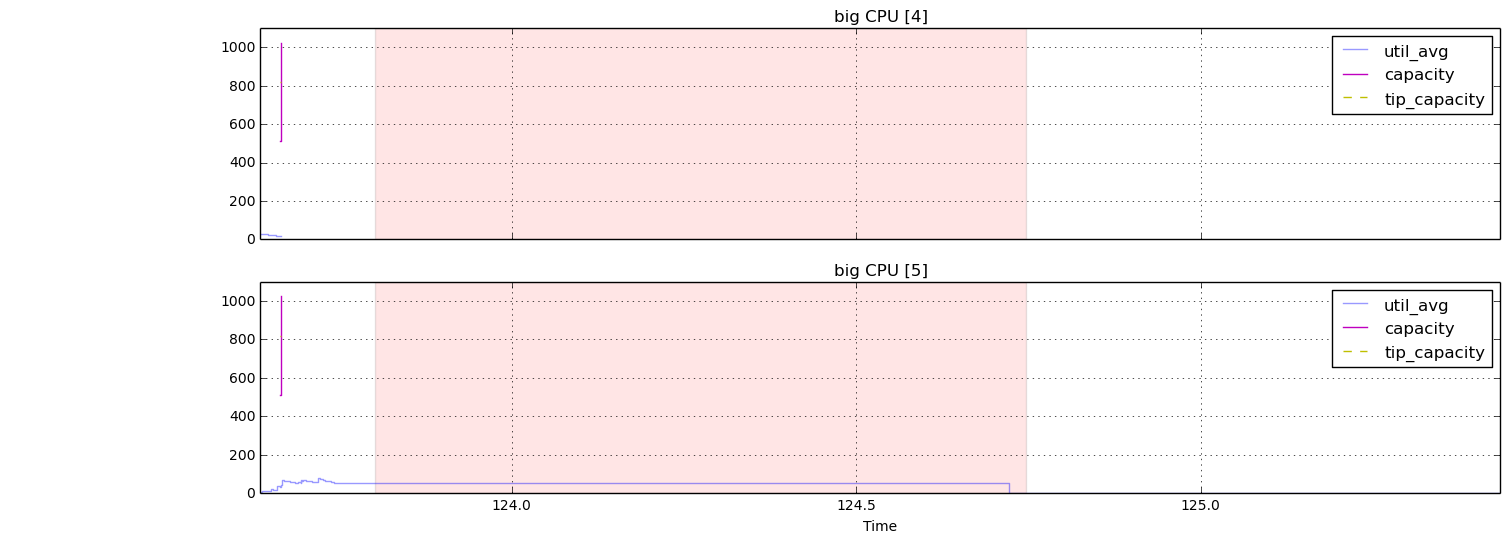

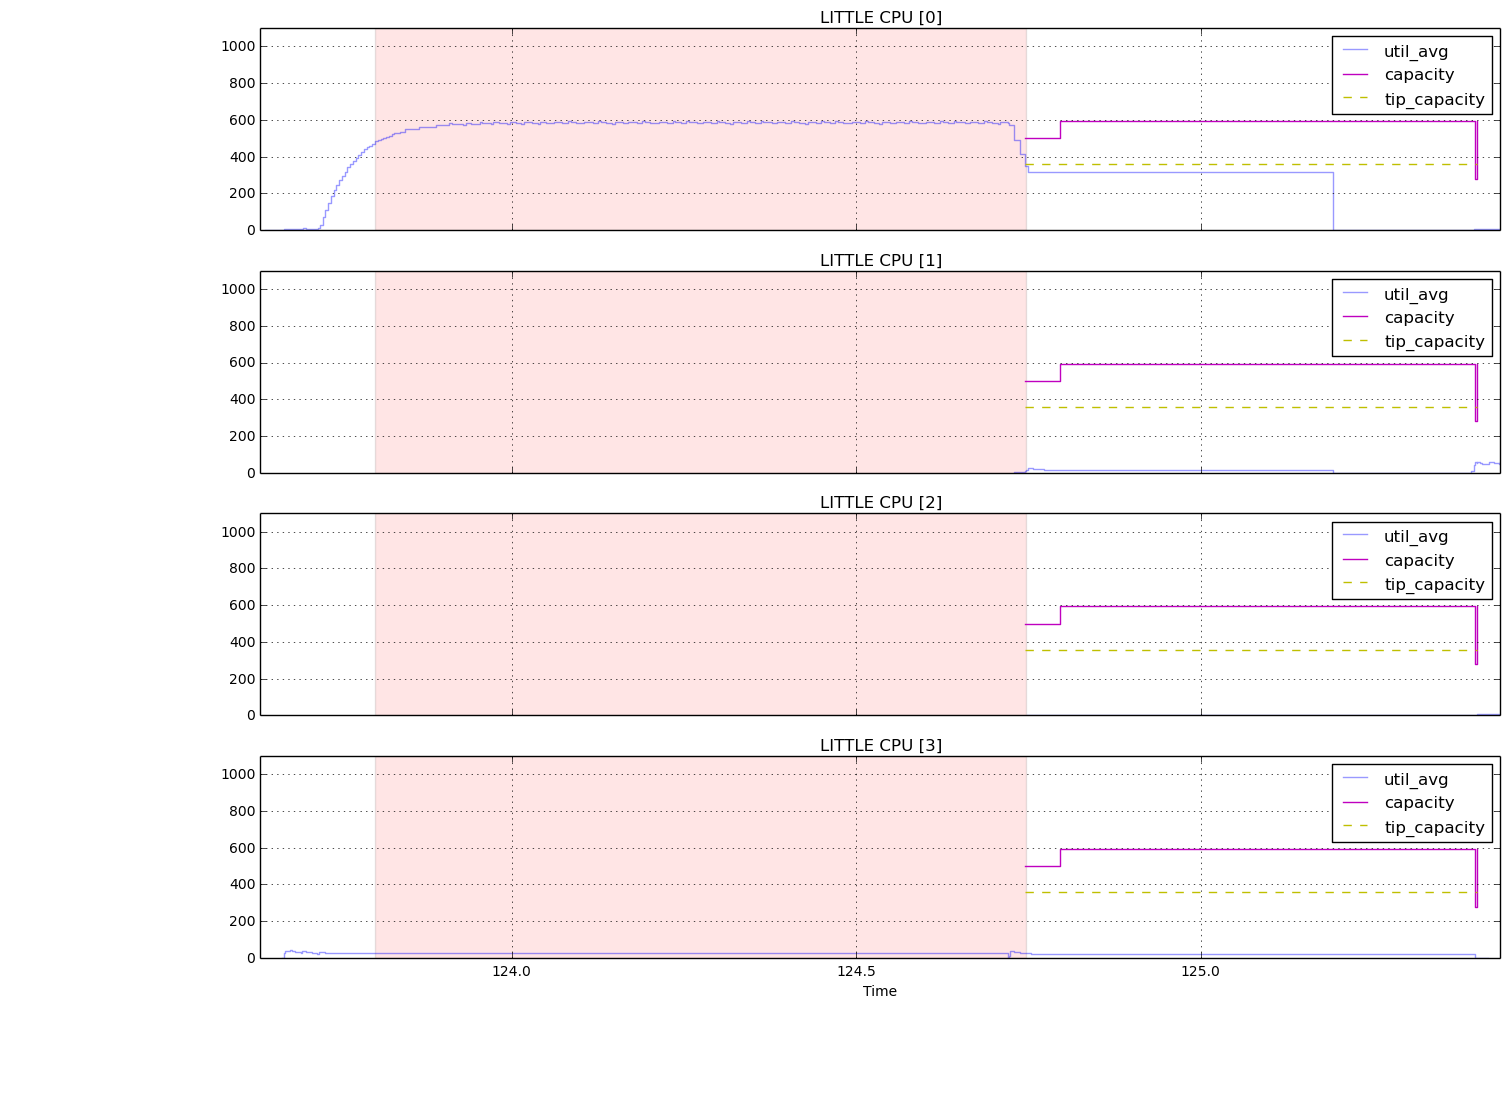

In [8]:
# Plot some stuff
trace.analysis.cpus.plotCPU()

In [9]:
# Simulations done
target.disconnect()

2017-07-19 10:28:54,619 INFO    : gem5-connection : Gracefully terminating the gem5 simulation.
2017-07-19 10:28:56,068 INFO    : gem5-connection : Removing the temporary directory
